In [1]:
#
# IE 678 Deep Learning, University of Mannheim
# Author: Rainer Gemulla

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import base64
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern, ExpSineSquared, RationalQuadratic

from IPython import get_ipython
from util import nextplot

%matplotlib notebook

# 1 Basic Hyperparameter Tuning

## 1a Manual search

In [2]:
# This is the function we are going to optimize. Do not look at this function yet (e.g.,
# do not decode the function body and do not evaluate it).
@np.vectorize
def f1(*args):
    x = np.array(args)
    return eval(
        base64.b64decode(
            b"LW5wLnByb2QobnAuc3FydChucC5hYnMoeCkqMTApKm5wLnNpbih4KjEwKSk="
        )
    )

In [3]:
# This helper function plots a number of 2D inputs along with their value.
def plotp(X, y):
    if len(X.shape) != 2 or X.shape[1] != 2 or X.shape[0] != len(y):
        raise ValueError

    x1, x2 = X[:, 0], X[:, 1]
    plot = plt.scatter(x1, x2, c=y, cmap=matplotlib.cm.coolwarm, s=500)
    plt.gca().set_aspect("equal")
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    for i in range(len(X)):
        plt.text(
            X[i, 0],
            X[i, 1],
            "{:.1f}".format(y[i]),
            va="center",
            ha="center",
            color="white",
        )
    plt.colorbar()

<IPython.core.display.Javascript object>


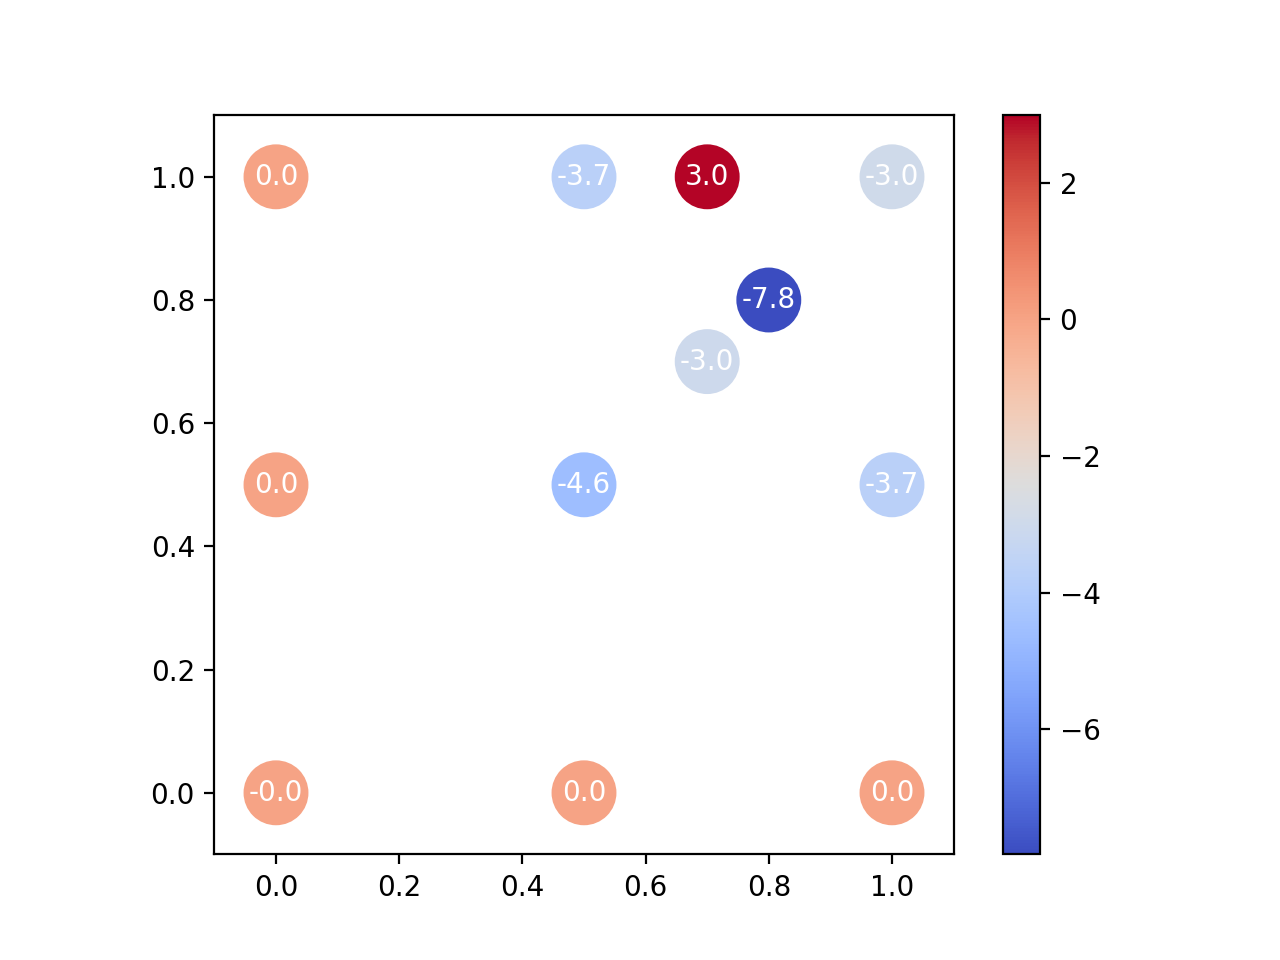

Your best trial so far is -7.8306379212935395 at [0.8 0.8]
You have 0 trials left.


In [17]:
nextplot()
X = np.array(
    [
        [0.5, 0.5],
        [0, 0],
        [1, 0],
        [0, 1],
        [0.5, 0],
        [0, 0.5],
        [1, 0.5],
        [0.5, 1],
        [0.7, 1],
        [0.7, 0.7],
        [0.8, 0.8],
        [1, 1],
        # Add 11 more points, one by one. Note that you can hover your mouse over a
        # region you'd like to explore to read of the corresponding coordinates.
        # YOUR CODE HERE
    ]
)
y = f1(X[:, 0], X[:, 1])
plotp(X, y)
print(f"Your best trial so far is {np.min(y)} at {X[np.argmin(y),:]}")
print(f"You have {12-len(X)} trials left.")

# ## 1b Discussion

In [19]:
# After you did a), uncomment these lines to see the true minimum.
x_min = np.array(eval(base64.b64decode(b"WzAuNzkxNywwLjc5MTdd")))
print(f"True minimum is {f1(*x_min)} at {x_min}.")
print(f"You found {np.min(y)} at {X[np.argmin(y),:]}.")

True minimum is -7.885600701977824 at [0.7917 0.7917].
You found -7.8306379212935395 at [0.8 0.8].


<IPython.core.display.Javascript object>


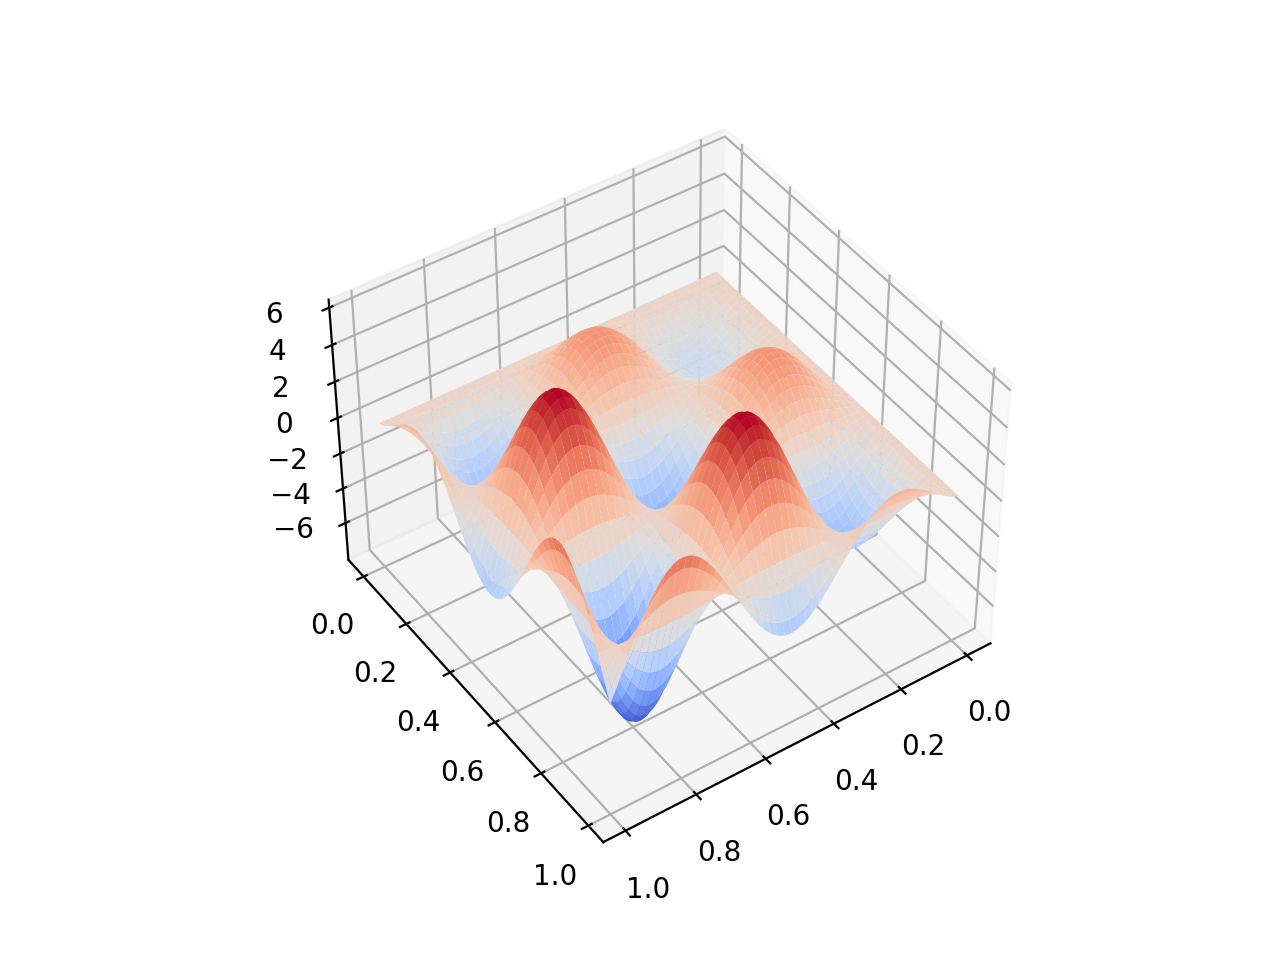

In [22]:
def plot3d(f):
    x1 = np.arange(0, 1, 0.01)
    x2 = np.arange(0, 1, 0.01)
    x1, x2 = np.meshgrid(x1, x2)
    z = f(x1, x2)
    ax = plt.gcf().add_subplot(projection="3d")
    ax.plot_surface(x1, x2, z, cmap=matplotlib.cm.coolwarm)


# After you did a), uncomment these lines to see the full function as 3d plot.
nextplot()
plot3d(f1)

<IPython.core.display.Javascript object>


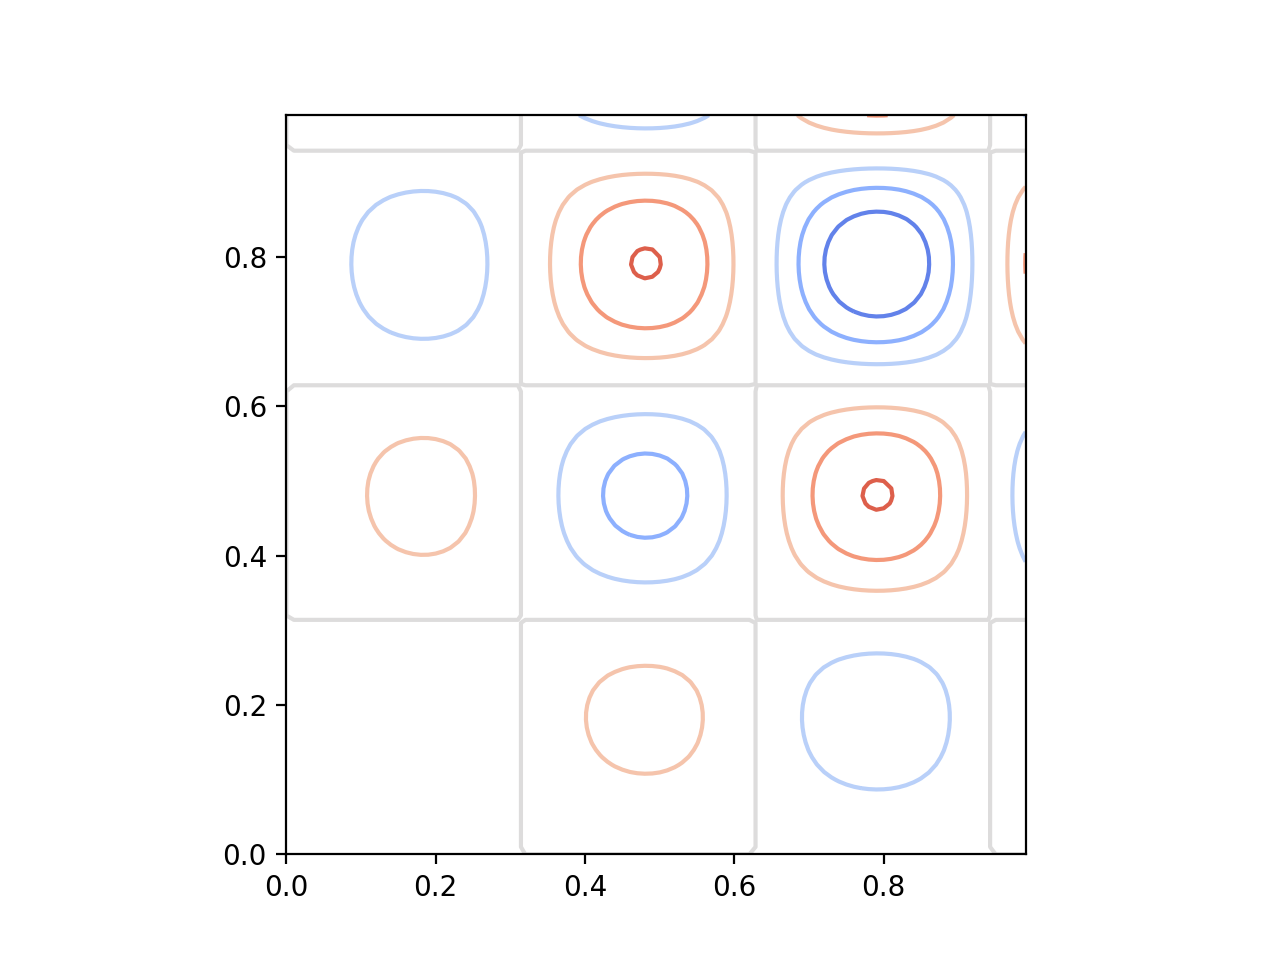

In [23]:
def plotc(f):
    x1 = np.arange(0, 1, 0.01)
    x2 = np.arange(0, 1, 0.01)
    x1, x2 = np.meshgrid(x1, x2)
    z = f(x1, x2)
    plt.contour(x1, x2, z, cmap=matplotlib.cm.coolwarm)
    plt.gca().set_aspect("equal")


# After you did a), uncomment these lines to see the full function as contour plot.
nextplot()
plotc(f1)

## 1c Grid search

<IPython.core.display.Javascript object>


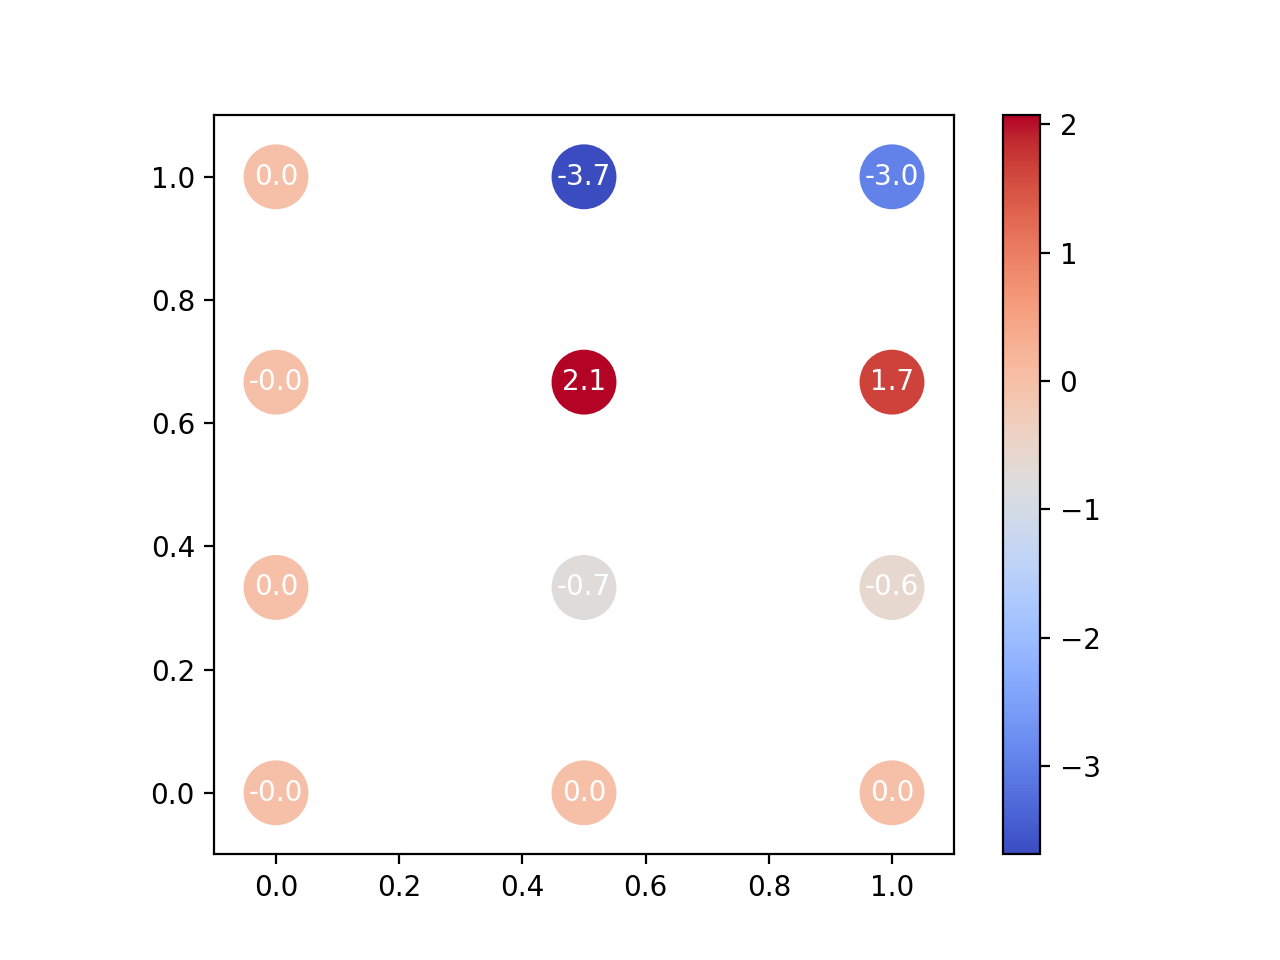

In [45]:
# Perform grid search with 12 trials. You may use plotp as above to visualize the
# results.
# YOUR CODE HERE
nextplot()
param1 = np.linspace(0, 1, 3)
param2 = np.linspace(0, 1, 4)

gs_configs = []
for _, p1 in enumerate(param1): 
    for _, p2 in enumerate(param2):
        gs_configs.append([p1, p2])
        
gs_configs = np.array(gs_configs)
y = f1(gs_configs[:, 0], gs_configs[:, 1])
plotp(gs_configs, y)

## 1d Random search

<IPython.core.display.Javascript object>


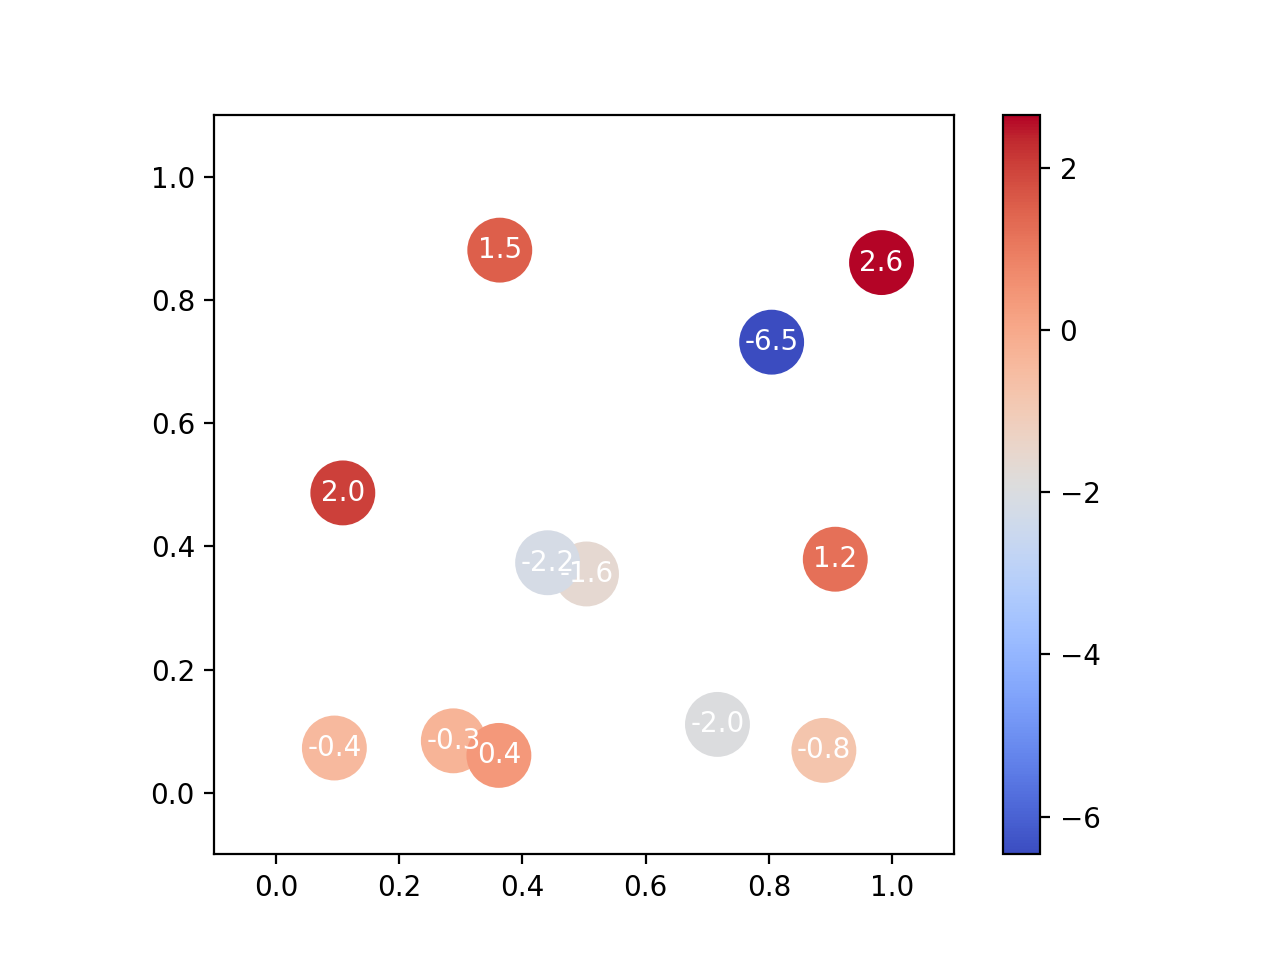

In [57]:
# Perform a random search with 12 trials.
# YOUR CODE HERE
nextplot()
rs_configs = []
for _ in range(12):
    sample = np.random.uniform(low=0.0, high=1.0, size=2)
    rs_configs.append(sample)

rs_configs = np.array(rs_configs)
y = f1(rs_configs[:, 0], rs_configs[:, 1])
plotp(rs_configs, y)

<IPython.core.display.Javascript object>


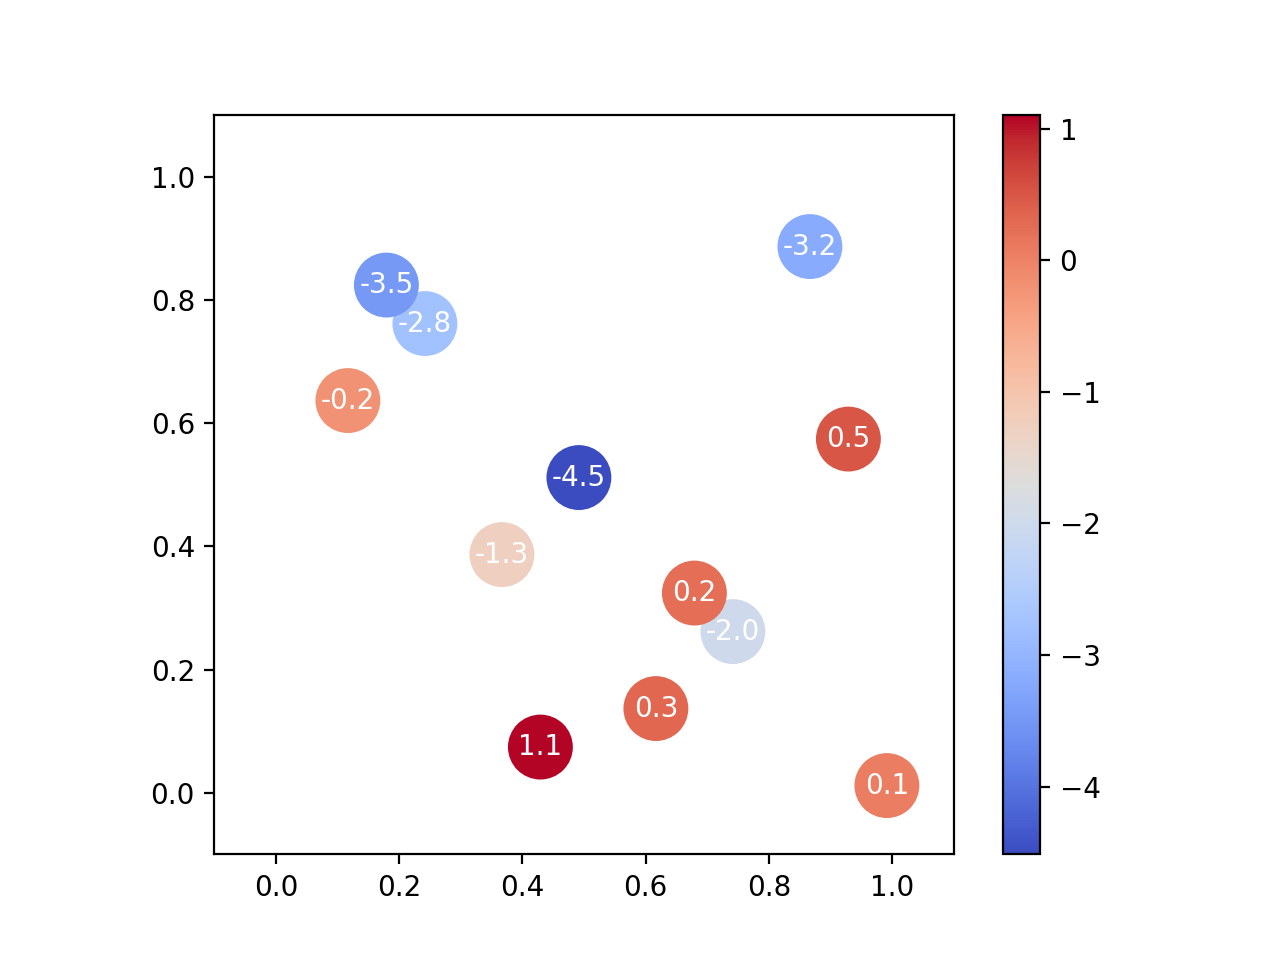

In [64]:
# Optional: Repeat using a Sobol sequence. You can generate Sobol trials as follows.
from skopt.sampler import Sobol  # pip install scikit-optimize

sobol = Sobol()
sb_configs = sobol.generate([(0.0, 1.0), (0.0, 1.0)], 12)
# YOUR CODE HERE
nextplot()
sb_configs = np.array(sb_configs)
y = f1(sb_configs[:, 0], sb_configs[:, 1])
plotp(sb_configs, y)

# 2 Gaussian Process Regression

## 2a Kernels

In [4]:
# The class of kernels we use in this task. The kernel is a scaled version of an RBF
# kernel. The argument "fixed" means that the kernel parameters (i.e., scale and
# length_scale) should not be optimized when fitting a GP with this kernel later.
def srbf(scale=1.0, length_scale=1.0, fixed=True):
    if fixed:
        return ConstantKernel(scale, constant_value_bounds="fixed") * RBF(
            length_scale, length_scale_bounds="fixed"
        )
    else:
        return ConstantKernel(scale) * RBF(length_scale)

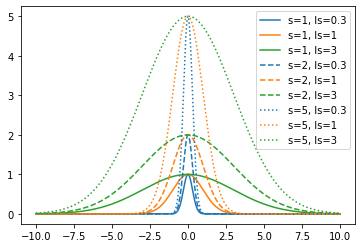

In [5]:
# Example kernels
nextplot()
x_all = np.linspace(-10, 10, 1000)
for i, scale in enumerate([1, 2, 5]):
    for j, length_scale in enumerate([0.3, 1, 3]):
        kernel = srbf(scale, length_scale)
        plt.plot(
            x_all,
            kernel(x_all.reshape(-1, 1), np.array([[0]])),
            color=f"C{j}",
            linestyle=["-", "--", ":"][i],
            label=f"s={scale}, ls={length_scale}",
        )
plt.legend()

## 2b GP prior

In [6]:
# This creates a GP prior with the default kernel (which is srbf(1,1)).
gp = GaussianProcessRegressor()

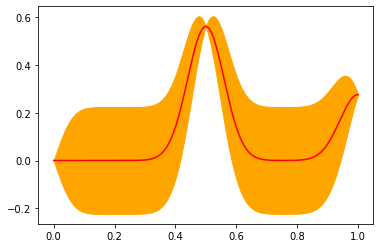

In [115]:
# Plot mean +- std_dev of a GP prior or posterior 
def plot_gp(gp):
    x_all = np.linspace(0, 1, 1000)

    # plot fit
    yhat_all, yhat_all_std = gp.predict(x_all.reshape(-1, 1), return_std=True)
    plt.plot(x_all, yhat_all, color="red")
    plt.fill_between(
        x_all, yhat_all - yhat_all_std, yhat_all + yhat_all_std, color="orange"
    )

nextplot()
plot_gp(gp)

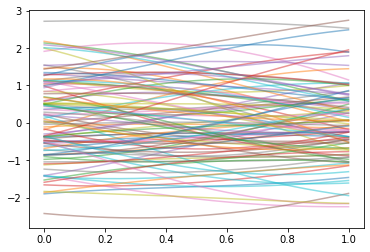

In [17]:
# Sample from a GP.
# Plot samples from a GP prior or posterior
def plot_gp_samples(gp, n=100, alpha=0.5):
    x_all = np.linspace(0, 1, 1000)
    plt.plot(x_all, gp.sample_y(x_all.reshape(-1,1), n), alpha=alpha)

nextplot()
plot_gp_samples(gp, 100)

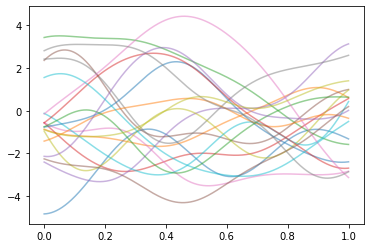

In [98]:
# Experiment with different kernels
# YOUR CODE HERE
scaled_rbf = ConstantKernel(constant_value=3, constant_value_bounds="fixed") * RBF(length_scale=0.2, length_scale_bounds="fixed")
gp_rbf = GaussianProcessRegressor(kernel=scaled_rbf)
plot_gp_samples(gp=gp_rbf, n=20)

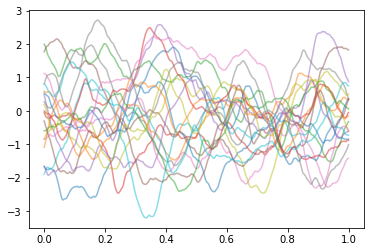

In [100]:
gp_rbf = GaussianProcessRegressor(kernel=Matern(length_scale=0.1, nu=1.5))
plot_gp_samples(gp=gp_rbf, n=20)

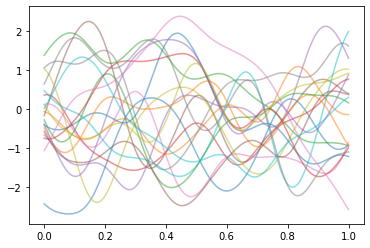

In [60]:
# like SE kernel
gp_rbf = GaussianProcessRegressor(kernel=Matern(length_scale=0.1, nu=np.inf))
plot_gp_samples(gp=gp_rbf, n=20)

## 2c GPR

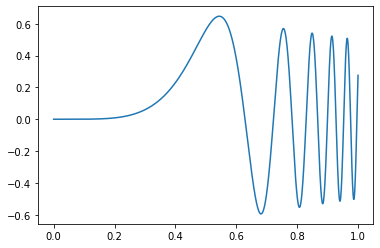

In [61]:
# We are working with this function. With your knowledge of the function, what would be
# a suitable scale and length scale?
def f2(x):
    return np.sin((2.0 * x) ** 5.0) / (x + 1)

def plot_f2():
    # show function itself
    x_all = np.linspace(0, 1, 1000)
    plt.plot(x_all, f2(x_all))

nextplot()
plot_f2()

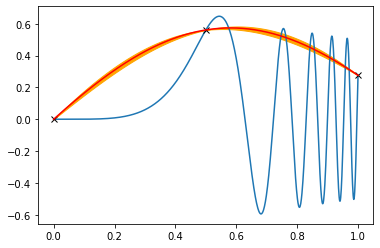

In [62]:
# Plot the posterior distribution of GPR (here using the default kernel)
x = np.linspace(0, 1, 3)
y = f2(x)
gp = GaussianProcessRegressor().fit(x.reshape(-1,1), y)

nextplot()
plot_f2()
plt.plot(x,y, "x", color="black")
plot_gp(gp)

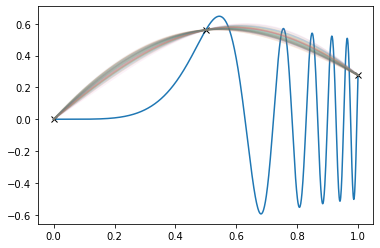

In [63]:
# Samples of the posterior can be plotted similarly.
nextplot()
plot_f2()
plt.plot(x,y, "x", color="black")
plot_gp_samples(gp, 50, alpha=0.1)

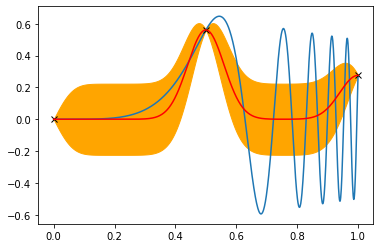

In [116]:
# Now use your estimated kernel parameters. Discuss.
# YOUR CODE HERE
nextplot()
scaled_rbf = ConstantKernel(constant_value=0.05, constant_value_bounds="fixed") * RBF(length_scale=0.06, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=scaled_rbf).fit(x.reshape(-1,1), y)
plot_f2()
plt.plot(x,y, "x", color="black")
plot_gp(gp=gp)

## 2d Experimentation

In [ ]:
# Experiment with different kernels and number of examples.
# YOUR CODE HERE

# 3 Bayesian Optimization

In [ ]:
# YOUR CODE HERE